# Import Library

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import random

# Access the Data & cleaning

In [54]:
df=pd.read_csv("/content/Ultimate_2019_2022_FixedTilt_Data.csv")
df['Timestamp'] = pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])
df.set_index('Timestamp', inplace=True)

In [55]:
df['hour'] = df.index.hour
df['dayofyear'] = df.index.dayofyear

In [56]:
features = ['DHI', 'DNI', 'Temperature', 'Relative Humidity', 'hour', 'dayofyear']
target = 'GHI'

In [57]:
df_cleaned = df[features + [target]].dropna()

In [58]:
df_cleaned.head()

,DHI,DNI,Temperature,Relative Humidity,hour,dayofyear,GHI
Timestamp,,,,,,,
2019-01-01 00:00:00,0.0,0.0,9.8,96.43,0,1,0.0
2019-01-01 01:00:00,0.0,0.0,9.5,96.16,1,1,0.0
2019-01-01 02:00:00,0.0,0.0,9.3,95.73,2,1,0.0
2019-01-01 03:00:00,0.0,0.0,9.1,95.51,3,1,0.0
2019-01-01 04:00:00,28.0,33.0,9.6,91.57,4,1,30.0


# Scaling the Data

In [59]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_cleaned)
data = pd.DataFrame(data_scaled, columns=features + [target], index=df_cleaned.index)

In [60]:
print(df.columns.tolist())

['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Cloud Type', 'Dew Point', 'DHI', 'DNI', 'Fill Flag', 'GHI', 'Relative Humidity', 'Solar Zenith Angle', 'Surface Albedo', 'Pressure', 'Precipitable Water', 'Wind Direction', 'Wind Speed', 'Si (BPR)', 'Si (Wacker)', 'Si (Eurosil)', 'GaAs (Bauhuis et al., 2009)', 'InGap (Gray, 2008)', 'InGap (McGambridge, 2011)', 'CdTe', 'Solar Azimuth Angle', 'Panel Tilt', 'Panel Azimuth Angle', '0.2800 um', '0.2805 um', '0.2810 um', '0.2815 um', '0.2820 um', '0.2825 um', '0.2830 um', '0.2835 um', '0.2840 um', '0.2845 um', '0.2850 um', '0.2855 um', '0.2860 um', '0.2865 um', '0.2870 um', '0.2875 um', '0.2880 um', '0.2885 um', '0.2890 um', '0.2895 um', '0.2900 um', '0.2905 um', '0.2910 um', '0.2915 um', '0.2920 um', '0.2925 um', '0.2930 um', '0.2935 um', '0.2940 um', '0.2945 um', '0.2950 um', '0.2955 um', '0.2960 um', '0.2965 um', '0.2970 um', '0.2975 um', '0.2980 um', '0.2985 um', '0.2990 um', '0.299

In [61]:
# Step 4: Select features and target
features = ['GHI', 'DHI', 'DNI', 'Temperature', 'Relative Humidity', 'hour', 'dayofyear']
target = 'GHI'

In [62]:
X, y = [], []
lookback = 72
forecast_horizon = 24

data = df[features + [target]].dropna().values

for i in range(lookback, len(data) - forecast_horizon):
    X.append(data[i - lookback:i, :-1])  # past features
    y.append(data[i:i + forecast_horizon, -1])  # future GHI

X = np.array(X)
y = np.array(y)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (34968, 72, 7), y shape: (34968, 24)


In [63]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}")

Train shapes: X=(27974, 72, 7), y=(27974, 24)
Test shapes: X=(6994, 72, 7), y=(6994, 24)


In [64]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=False),
    Dense(128, activation='relu'),
    Dense(24)  # 24-hour forecast
])

model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [66]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 152612.0469 - val_loss: 100878.6562
Epoch 2/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 112916.0547 - val_loss: 92872.1328
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 93547.0469 - val_loss: 60818.5156
Epoch 4/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 60596.9062 - val_loss: 23774.5137
Epoch 5/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 24088.6426 - val_loss: 19076.5957
Epoch 6/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 18489.6758 - val_loss: 12051.4092
Epoch 7/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 11150.9766 - val_loss: 6366.3706
Epoch 8/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 6250.7690 - val_loss: 4399.1108
Epoch 9/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 4621.0938 - val_loss: 4075.7729
Epoch 10/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 4243.6577 - val_loss: 4057.1689
Epoch 11/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 4

In [67]:
y_pred = model.predict(X_test)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [68]:
dummy_features_test = np.zeros((y_test.shape[0], y_test.shape[1], data_scaled.shape[-1] - 1))
y_test_full = np.concatenate((dummy_features_test, y_test[:, :, np.newaxis]), axis=-1)
y_test_unscaled = scaler.inverse_transform(y_test_full.reshape(-1, y_test_full.shape[-1])).reshape(y_test_full.shape)[:, :, -1]

dummy_features_pred = np.zeros((y_pred.shape[0], y_pred.shape[1], data_scaled.shape[-1] - 1))
y_pred_full = np.concatenate((dummy_features_pred, y_pred[:, :, np.newaxis]), axis=-1)
y_pred_unscaled = scaler.inverse_transform(y_pred_full.reshape(-1, y_pred_full.shape[-1])).reshape(y_pred_full.shape)[:, :, -1]


mse = mean_squared_error(y_test_unscaled.flatten(), y_pred_unscaled.flatten())
print("Test MSE:", mse)

Test MSE: 5736916302.386148


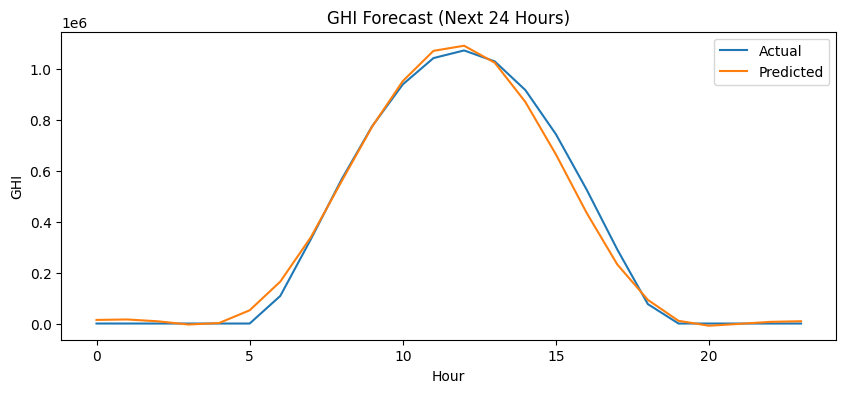

In [89]:
idx = random.randint(0, len(y_test_unscaled) - 1)

plt.figure(figsize=(10,4))
plt.plot(y_test_unscaled[idx], label='Actual')
plt.plot(y_pred_unscaled[idx], label='Predicted')
plt.title("GHI Forecast (Next 24 Hours)")
plt.xlabel("Hour")
plt.ylabel("GHI")
plt.legend()
plt.show()

In [90]:
model.save("2019_2022_FixedTilt_ghi_forecast_model.h5")
print("Model saved as 2019_2022_FixedTilt_ghi_forecast_model.h5")

Model saved as 2019_2022_FixedTilt_ghi_forecast_model.h5


In [91]:
model.save("2019_2022_FixedTilt_ghi_forecast_model.keras")
print("Model saved as 2019_2022_FixedTilt_ghi_forecast_model.keras")

Model saved as 2019_2022_FixedTilt_ghi_forecast_model.keras
